# Civic Engagement with Data Science

---

Alexander Poon  
PyNash  
November 2018

## Hello, PyNash

* Background in Public Policy and Education
* Director of Analytics at Tennessee Department of Education
* Aspiring AI/ML practitioner and Python learner

## This Project

**What (state) legislation should I pay attention to?**

Preliminaries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_colwidth = 1000

## The Data

**OpenStates** provides comprehensive information pertaining to state legislators and legislation, including bill text, topics, sponsors, progress through committees, amendments, vote tallies and votes by individual legislators.

In [ ]:
from pyopenstates import *

import os
# First put your key in an environment variable with:
#   $ export OPENSTATESAPIKEY=<your_key>
# This prevents it from accidentally getting saved and published in the code.
set_api_key(os.environ['OPENSTATESAPIKEY']) # Get key here: https://openstates.org/api/register/

bills_request = search_bills(state='tn')

In [3]:
bills_request[0].keys()

dict_keys(['title', 'summary', 'created_at', 'updated_at', 'id', 'all_ids', 'chamber', 'state', 'session', 'type', 'bill_id', 'actions', 'sources', 'sponsors', 'versions', 'documents', 'alternate_titles', 'votes', 'action_dates', 'scraped_subjects', 'alternate_bill_ids', 'subjects', 'companions'])

In [4]:
bills = pd.read_csv('../data/bills.csv')

# Remove the 'Amends TCA Title x, Chapter y' from bill titles
bills['title'].replace(to_replace=' - Amends.+$', value='', regex=True, inplace=True)

Convert a list of dictionaries to a Pandas DataFrame:

In [ ]:
bills = pd.DataFrame(bills_request) \
    .loc[:, ['bill_id', 'session', 'subjects', 'title', 'sponsors']]

# Remove the 'Amends TCA Title x, Chapter y' from bill titles
bills['title'].replace(to_replace=' - Amends.+$', value='', regex=True, inplace=True)

In [5]:
bills.head(2)

,bill_id,session,subjects,title,sponsors
0,SB 107,110,Government Reform,"Sunset Laws - As enacted, extends the Tennessee life and health insurance guaranty association five years to June 30, 2022.",Bell; Faison
1,HB 228,110,Government Reform,"Sunset Laws - As enacted, extends the Tennessee life and health insurance guaranty association five years to June 30, 2022.",Faison; Bell


![](images/text.png)

## The problem

In [6]:
len(bills)

20089

This represents the last four legislative sessions (each legislative session runs two years).

## This Project

**What (state) legislation should I pay attention to?**

This might include legislation that:
- pertains to local issues in the city/town/county where I live
- pertains to issues I care about
- is introduced by my Representative/Senator

`pyopenstates` can identify my legislators:

In [7]:
my_legislators = [i.get('last_name') for i in locate_legislators(36.157612, -86.767337)]

print(my_legislators)

['Beck', 'Harper']


Tag legislation introducted by my legislators:

In [8]:
bills['my_legislators'] = bills['sponsors'].str.contains('|'.join(my_legislators)) \
    .fillna(False) \
    .astype(int)

Tag legislation pertaining to my county/city/town:

In [9]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='12345')

location = geolocator.reverse((36.157612, -86.767337))

my_city, my_county = [location.raw.get('address').get(i) for i in ['city', 'county']]

print(my_city + ', ' + my_county)

Nashville-Davidson, Davidson County


In [10]:
if my_city == "Nashville-Davidson":
    my_city = "Nashville"

# Tag legislation mentioning my city or county from location
bills['my_city_county'] = bills['title'].str.contains(my_city + '|' + my_county) \
    .astype(int)

Tag legislation pertaining to subjects I'm interested in:

(What are possible subjects?)

In [11]:
bills['subjects'].replace(to_replace=';.+', value='', regex=True) \
    .value_counts()

Education                               2461
Legal Issues                            1985
Health                                  1396
Transportation                          1253
Municipal and County Issues             1181
Budget, Spending, and Taxes             1035
Drugs                                   1017
Government Reform                        959
Labor and Employment                     822
Business and Consumers                   611
Housing and Property                     610
Commerce                                 591
Crime                                    588
Campaign Finance and Election Issues     485
Federal, State, and Local Relations      456
Judiciary                                427
Environmental                            396
Legislative Affairs                      386
Guns                                     336
Family and Children Issues               328
Public Services                          297
Other                                    277
State Agen

In [12]:
bills['subjects'].replace(to_replace=';.+', value='', regex=True) \
    .value_counts() \
    .tail(20)

State Agencies                          266
Agriculture and Food                    247
Military                                220
Senior Issues                           167
Animal Rights and Wildlife Issues       118
Welfare and Poverty                     117
Recreation                              100
Resolutions                              99
Social Issues                            96
Technology and Communication             81
Reproductive Issues                      66
Arts and Humanities                      56
Civil Liberties and Civil Rights         44
Gambling and Gaming                      40
Energy                                   39
Immigration                              38
Science and Medical Research             26
Insurance                                12
Sexual Orientation and Gender Issues      7
Trade                                     4
Name: subjects, dtype: int64

Tag legislation pertaining to subjects I'm interested in:

In [13]:
my_subjects = ['Education']

bills['my_subjects'] = bills['subjects'].str.contains('|'.join(my_subjects)) \
    .fillna(False) \
    .astype(int)

In [14]:
pd.options.display.max_colwidth = 50

In [15]:
bills.head(2)

,bill_id,session,subjects,title,sponsors,my_legislators,my_city_county,my_subjects
0,SB 107,110,Government Reform,"Sunset Laws - As enacted, extends the Tennesse...",Bell; Faison,0,0,0
1,HB 228,110,Government Reform,"Sunset Laws - As enacted, extends the Tennesse...",Faison; Bell,0,0,0


## How a Bill Becomes a Law

In Tennessee, a bill goes through the following [steps](http://www.capitol.tn.gov/about/billtolaw.html) (roughly) to become law:

* Introduced
* Passed on First Consideration
* Passed on Second Consideration
* Referred to Committee(s)
* Placed on Calendar for Third Consideration
    * On Third Consideration, opened for debate and amendment
* Passed on Third Consideration
* Reconcile Senate and House versions
* Signed by Governor or allowed to become law without signature

Pull this information using `get_bill()`:

In [16]:
get_bill(state='tn', term=110, bill_id='SB 107').keys()

dict_keys(['title', 'summary', 'created_at', 'updated_at', 'id', 'all_ids', 'chamber', 'state', 'session', 'type', 'bill_id', 'actions', 'sources', 'sponsors', 'versions', 'documents', 'alternate_titles', 'votes', 'action_dates', 'scraped_subjects', 'alternate_bill_ids', 'subjects', 'companions'])

In [17]:
get_bill(state='tn', term=110, bill_id='SB 107').get('actions')

[{'action': 'Filed for introduction',
  'actor': 'upper',
  'date': '2017-01-12 00:00:00',
  'related_entities': [],
  'type': ['bill:introduced', 'bill:reading:1']},
 {'action': 'Introduced, Passed on First Consideration',
  'actor': 'upper',
  'date': '2017-01-30 00:00:00',
  'related_entities': [],
  'type': ['bill:introduced']},
 {'action': 'Filed for intro.',
  'actor': 'lower',
  'date': '2017-01-31 00:00:00',
  'related_entities': [],
  'type': ['bill:introduced', 'bill:reading:1']},
 {'action': 'Passed on Second Consideration, refer to Senate Government Operations Committee',
  'actor': 'upper',
  'date': '2017-02-01 00:00:00',
  'related_entities': [],
  'type': []},
 {'action': 'Intro., P1C.',
  'actor': 'lower',
  'date': '2017-02-01 00:00:00',
  'related_entities': [],
  'type': ['bill:introduced']},
 {'action': 'P2C, ref. to Government Operations Committee',
  'actor': 'lower',
  'date': '2017-02-02 00:00:00',
  'related_entities': [],
  'type': ['committee:referred']},
 {

Pull this information for all bills and turn into a DataFrame:

In [ ]:
actions = pd.DataFrame()

for s, b in zip(bills['session'], bills['bill_id']):
    actions = pd.concat(
        [actions,
         pd.DataFrame(get_bill(state='tn', term=s, bill_id=b).get('actions'))
             .assign(session=s, bill_id=b)]
    )

In [18]:
actions = pd.read_csv('../data/actions.csv')

actions.drop_duplicates(['action', 'actor', 'date', 'session', 'bill_id'], inplace=True)
actions['action'].fillna('', inplace=True)

intro = actions.query('action.str.contains("Filed for introduction|Filed for intro.")', engine='python') \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(introduced=1)

first = actions.query('action.str.contains("Passed on First Consideration|P1C")', engine='python') \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(first=1)

second = actions.query('action.str.contains("Passed on Second Consideration|P2C")', engine='python') \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(second=1)

committee = actions.query('action.str.contains("H. Placed on Regular Calendar|H. Placed on Consent Calendar|Placed on Senate Consent Calendar|Placed on Senate Regular Calendar")', engine='python') \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(committee=1)

chamber = actions.query('action.str.contains("Passed H.|Passed Senate|Passed S.")', engine='python') \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(chamber=1)

signed = actions.query('action.str.contains("Signed by Governor")', engine='python') \
    .loc[:, ['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(signed=1)

In [19]:
actions.head(10)

,action,actor,session,bill_id,type,ayes,nays
0,Filed for introduction,upper,110,SB 107,bill:reading:1; bill:introduced,NaN,NaN
1,"Introduced, Passed on First Consideration",upper,110,SB 107,bill:introduced,NaN,NaN
2,Filed for intro.,lower,110,SB 107,bill:reading:1; bill:introduced,NaN,NaN
3,"Passed on Second Consideration, refer to Senat...",upper,110,SB 107,other,NaN,NaN
4,"Intro., P1C.",lower,110,SB 107,bill:introduced,NaN,NaN
5,"P2C, ref. to Government Operations Committee",lower,110,SB 107,committee:referred,NaN,NaN
6,Placed on Senate Government Operations Committ...,upper,110,SB 107,other,NaN,NaN
7,"Recommended for passage, refer to Senate Calen...",upper,110,SB 107,other,NaN,NaN
8,Placed on Senate Consent Calendar 2 calendar f...,upper,110,SB 107,other,NaN,NaN
9,Placed on cal. Government Operations Committee...,lower,110,SB 107,other,NaN,NaN


Identify the relevant major steps:

In [ ]:
intro = actions.query('action.str.contains("Filed for introduction|\
                                            Filed for intro.")',
            engine='python') \
    .assign(introduced=1)

first = actions.query('action.str.contains("Passed on First Consideration|\
                                            P1C")',
            engine='python') \
    .assign(first=1)

second = actions.query('action.str.contains("Passed on Second Consideration|\
                                             P2C")',
            engine='python') \
    .assign(second=1)

committee = actions.query('action.str.contains("H. Placed on Regular Calendar|\
                                                H. Placed on Consent Calendar|\
                                                Placed on Senate Consent Calendar|\
                                                Placed on Senate Regular Calendar")',
            engine='python') \
    .assign(committee=1)

chamber = actions.query('action.str.contains("Passed H.|Passed Senate|Passed S.")',
            engine='python') \
    .assign(chamber=1)

signed = actions.query('action.str.contains("Signed by Governor")',
            engine='python') \
    .assign(signed=1)

How many bills make it past each step?

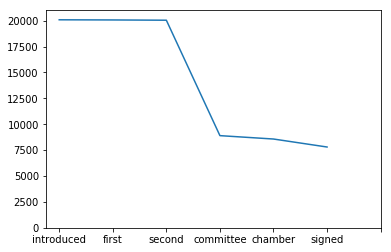

In [20]:
bills = bills \
    .merge(intro, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(first, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(second, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(committee, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(chamber, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(signed, how='left', on=['session', 'bill_id'], validate='1:1') \
    
bills[['introduced', 'first', 'second', 'committee', 'chamber', 'signed']].agg(sum) \
    .plot(xticks=range(7), ylim=(0, 21000))

The big gatekeeper is getting past committees; most bills don't get past committee, but once they do, they stand a good chance of passing.

What do vote margins (yes votes - no votes) look like once bills get past committee?

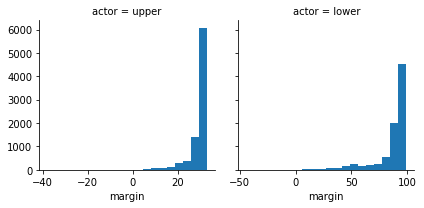

In [21]:
margin = actions.query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine='python') \
    .assign(margin = actions['ayes'] - actions['nays']) \
    .loc[:, ['session', 'bill_id', 'actor', 'margin']]

g = sns.FacetGrid(margin, col="actor", sharex=False)
g = g.map(plt.hist, "margin", bins=20)

Once past committee, many bills are uncontroversial (pass by an all-0 vote). I'll also tag uncontroversial bills so I can deprioritize these.

In [ ]:
actions['uncontroversial'] = pd.Series(actions['nays'] <= 1).astype(int)

uncontroversial = actions \
    .query('action.str.contains("Failed to pass H.|Failed to pass Senate|\
                                 Passed H.|\
                                 Passed Senate|Passed S.")',
        engine='python')

bills = bills.merge(uncontroversial, how='left', on=['session', 'bill_id'], validate='1:1')

In [22]:
actions['uncontroversial'] = pd.Series(actions['nays'] <= 1).astype(int)

uncontroversial = actions \
    .query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine='python') \
    .query('actor == "upper" & bill_id.str.contains("SB") | actor == "lower" & bill_id.str.contains("HB")', engine='python') \
    .groupby(['session', 'bill_id']) \
    .agg({'uncontroversial': 'min'}) \
    .reset_index(drop=False)

bills = bills.merge(uncontroversial, how='left', on=['session', 'bill_id'], validate='1:1')

bills['uncontroversial'].fillna(0, inplace=True)

# This Project

**What (state) legislation should I pay attention to?**

This might include legislation that:
- pertains to local issues in the city/town/county where I live
- pertains to issues I care about
- is introduced by my Representative/Senator

and might not include legislation that:

- is uncontroversial (e.g., probably going to pass unanimously)
- has no chance of passing (e.g.: not even going to a vote)

![](images/venn1.png)

![](images/venn2.png)

Of course, we can identify how bills fare retrospectively.

It would be helpful to know (or make an informed guess at) whether bills will go to a vote and/or be uncontroversial as they are introduced so that one might be able to influence legislation by calling legislators, etc.

I use **machine learning** to predict these outcomes.

## The Idea:

We know which bills have gone to a vote/been uncontroversial in the past.

The idea is to use any information (sponsors, topics, **text**) about what bills have gone to a vote/been uncontroversial in the past to predict which bills will go to a vote/be uncontroversial in the future.

## Future bills?

To mimic prediction, I build models using the 107-109th sessions and treat bills from the 110th as 'future bills'.

In [23]:
bills['session'].value_counts()

110    5485
109    5357
108    5204
107    4043
Name: session, dtype: int64

I can then evaluate my predictions by checking against what really happened:

| Session  |  ID   |    Prediction   |  Outcome |
|----------|-------|-----------------|----------|
|    110   | HB 10 |    Pass   |     Pass     |
|    110   | HB 11 |    Pass   |    Not Pass  |
|    110   | HB 12 | Not Pass  |    Not Pass  |
|    110   | HB 13 |    Pass   |     Pass     |
|    110   | HB 14 |    Pass   |    Not Pass  |
|    110   |   .   | . | . |
|    110   |   .   | . | . |
|    110   |   .   | . | . |

## Problem

Machine learning algorithms expect numeric inputs, and I have text.

## Solution

Use Natural Language Processing to create a numeric representation of text!

## Natural Language Processing

From [Wikipedia](https://en.wikipedia.org/wiki/Natural-language_processing):

[A] field of computer science, artificial intelligence concerned with the interactions between computers and human (natural) languages, and, in particular, concerned with **programming computers to fruitfully process large natural language data**.

i.e.: creating numeric representations of text and doing statistics, data visualization, modeling.

## A Sample Title

Students - As enacted, requires a student, during the student's high school career, to take a United States civics test.

## Preprocessing Text

I do some preprocessing by running my text through the [spaCy](https://spacy.io/) [annotator](https://demos.explosion.ai/displacy/), which identifies:

- (Word) Tokens
- Parts of speech (nouns, verbs, adjectives, etc.)
- Named entities (United States)
- Lemmas (taught, teaching, teaches -> teach; teachers -> teacher)

![](images/annotation.png)

Annotating a sample piece of text with spaCy:

In [24]:
import spacy

nlp = spacy.load('en')

doc = nlp("As enacted, requires a student, during the student's high school career, to take a United States civics test.")

annotation_sample = pd.DataFrame({
    'text': [n.text for n in doc],
    'lemma': [n.lemma_ for n in doc],
    'pos': [n.pos_ for n in doc]
})

In [25]:
annotation_sample[annotation_sample['pos'] != 'PUNCT']

,lemma,pos,text
0,as,ADP,As
1,enact,VERB,enacted
3,require,VERB,requires
4,a,DET,a
5,student,NOUN,student
7,during,ADP,during
8,the,DET,the
9,student,NOUN,student
10,'s,PART,'s
11,high,ADJ,high


Annotating text at scale with spaCy:

In [26]:
import spacy

# Use spaCy annotator and convert to data frame with one token per row
nlp = spacy.load('en')

token = []
lemma = []
pos = []

for doc in nlp.pipe(bills['title'], batch_size = 50):
    token.append([n.text for n in doc])
    lemma.append([n.lemma_ for n in doc])
    pos.append([n.pos_ for n in doc])
    
annotation_df = pd.DataFrame({
    'token': pd.Series(token).apply(pd.Series).stack(),
    'lemma': pd.Series(lemma).apply(pd.Series).stack(),
    'pos': pd.Series(pos).apply(pd.Series).stack(),
})

In [27]:
annotation_df.head(20)

lemma    pos        token
0 0        sunset  PROPN       Sunset
  1          laws  PROPN         Laws
  2             -  PUNCT            -
  3            as    ADP           As
  4         enact   VERB      enacted
  5             ,  PUNCT            ,
  6        extend   VERB      extends
  7           the    DET          the
  8     tennessee  PROPN    Tennessee
  9          life   NOUN         life
  10          and  CCONJ          and
  11       health   NOUN       health
  12    insurance   NOUN    insurance
  13     guaranty   NOUN     guaranty
  14  association   NOUN  association
  15         five    NUM         five
  16         year   NOUN        years
  17           to    ADP           to
  18         june  PROPN         June
  19           30    NUM           30

For my application, I keep certain parts of speech, replace tokens with their lemmas, and drop stop words:

In [28]:
from nltk.corpus import stopwords

# Drop and modify tokens depending of part of speech
# https://spacy.io/api/annotation#pos-tagging
annotation_df = annotation_df[annotation_df['pos'].isin(['NOUN', 'VERB', 'PROPN'])]

# Drop anything with nonword characters
annotation_df = annotation_df[~annotation_df['token'].str.contains("\\W|[0-9]")]

# Drop stopwords
annotation_df = annotation_df[~annotation_df['token'].isin(stopwords.words('english'))]

preprocess = pd.Series([annotation_df.loc[i]['lemma'].str.cat(sep=' ') for i in range(len(bills))])

In [29]:
preprocess[0]

'sunset laws enact extend tennessee life health insurance guaranty association year june'

## A Term Frequency Matrix

One way to quantitatively represent text: create a matrix where each row represents one bill, and each column represents one token. Each value is the number of times a token appears in a bill:

| ID | abandon |...| require | student | high | school | career | take | United | States | civics | test |...| zoning |
|------|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| HB10 | 0 |...| 1 | 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |...| 0 |
| HB11 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
| HB12 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |

This is a **bag of words** representation of a text document.

## A TF-IDF Matrix

I'll take this one step further, by calculating **T**erm **F**requency-**I**nverse **D**ocument **F**requency. [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) indicates which tokens show up frequently in one document (TF) while downweighting tokens that show up frequently across all documents (IDF).

For a corpus with N documents, the TF-IDF score for token *t* and document *d* is:

$$TFIDF_{(t, d)} = \#\:of\:times\:t\:appears\:in\:d\:*\: log \frac{\#\:of\:documents}{ \#\:of\:documents\:with\:t}$$

## A TF-IDF Matrix

| ID | abandon |...| require | student | high | school | career | take | United | States | civics | test |...| zoning |
|------|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| HB10 | 0 |...|0.089|0.553|0.268|0.151|0.365|0.246|0.272|0.272|0.419|0.274|...| 0 |
| HB11 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
| HB12 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |

Think of this as ~ highlighting important terms in a document.

I can do this with `TfidfVectorizer`:

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(min_df=10, ngram_range=(1, 3))

X_tfidf = tf.fit_transform(preprocess)

A TF-IDF representation of text will be the input to my machine learning model.

Split my dataset into a **test set** consisting of the most recent session and a **training set** consisting of all prior sets.

In [31]:
bills['session'].value_counts()

110    5485
109    5357
108    5204
107    4043
Name: session, dtype: int64

In [32]:
train_count = sum(bills['session'] != 110)

X_train = X_tfidf[:train_count].toarray()
X_test = X_tfidf[train_count:].toarray()

Likewise, split the outcomes into training and test components.

In [33]:
Y_train_vote = bills['committee'][:train_count]
Y_test_vote = bills['committee'][train_count:]

Y_train_uncontroversial = bills['uncontroversial'][:train_count]
Y_test_uncontroversial = bills['uncontroversial'][train_count:]

## To recap

I am trying to predict whether a bill will:

1. pass committees/go to a vote  
2. be uncontroversial

based on the presence of certain words/phrases in the Title field.

## Why might this work?

* The presence of certain words/phrases reliably predicts something about a bill's outcome.

## Why might this not work?

* Tendencies of bill outcomes change over time
    * Turnover in legislators AND new legislators have different tendencies than previous legislators
    * Legislators want to do the opposite of what they did previously
    * Bills need 'momentum' in order to pass
* New bills deal with different topics than old bills

## In machine learning parlance

- This is a **classification** problem (the outcome of interest is categorical: vote/no vote OR uncontroversial/not).
- I use a **logistic regression** with **elastic net regularization**.
- I use a **grid search** to iterate over values of the regularization paramenter and 5-fold **cross validation**.

## In English

I am asking the algorithm to identify a relationship between inputs (text) and outcomes **that generalizes as well as possible to new data**.

Building a model to predict whether a bill goes to a vote:

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'alpha': 10.0 ** -np.arange(3, 7)
}

elastic_net = GridSearchCV(SGDClassifier(loss="log", max_iter=250, l1_ratio=1), params, cv=5)

elastic_net_vote = elastic_net.fit(X_train, Y_train_vote)

## Evaluating classification predictions

About 44 percent of bills pass all committees and make it to a vote. This means I could achieve ~56% accuracy just by predicting 'no vote' for every bill.

I want my classification accuracy to be meaningfully above 56%.

In [35]:
bills['committee'].value_counts()

0.0    11188
1.0     8901
Name: committee, dtype: int64

Predict on the test set and check accuracy:

In [36]:
from sklearn.metrics import accuracy_score

predict_vote = elastic_net_vote.predict(X_test).astype(int)

accuracy_score(predict_vote, Y_test_vote)

0.9465815861440292

Repeat to predict uncontroversial bills:

In [37]:
bills['uncontroversial'].value_counts()

0.0    13245
1.0     6844
Name: uncontroversial, dtype: int64

In [38]:
elastic_net_uncontroversial = elastic_net.fit(X_train, Y_train_uncontroversial)

predict_uncontroversial = elastic_net_uncontroversial.predict(X_test).astype(int)

accuracy_score(predict_uncontroversial, Y_test_uncontroversial)

0.9279854147675478

An answer to "What legislation should I pay attention to?" might look like the following:

In [53]:
prediction_set = bills[bills['session'] == 110] \
    .assign(predict_vote = predict_vote,
            predict_uncontroversial = predict_uncontroversial) \
    .loc[:, ['title', 'my_legislators', 'my_city_county', 'my_subjects', 'predict_vote', 'predict_uncontroversial']]

# Count number of categories matched
prediction_set['counts'] = \
    prediction_set['my_city_county'] + \
    prediction_set['my_legislators'] + \
    prediction_set['my_subjects'] + \
    ((prediction_set['predict_vote'] == 1) & (prediction_set['predict_uncontroversial'] == 0)).astype(int)

# Sort results by descending order of the number of categories matched
prediction_set \
    .query('my_city_county == 1 | my_legislators == 1 | my_subjects == 1 | (predict_vote == 1 & predict_uncontroversial == 0)') \
    .sort_values(by = 'counts', ascending = False)

,title,my_legislators,my_city_county,my_subjects,predict_vote,predict_uncontroversial,counts
3844,"Education - As enacted, revises various provis...",0,0,1,1,0,2
143,"Education - As enacted, creates the ""Homeless ...",1,0,1,0,0,2
3786,"Education - As introduced, creates a tuition a...",0,0,1,1,0,2
584,"Education - As introduced, requires a local bo...",0,0,1,1,0,2
1455,"Education - As introduced, allows the governin...",0,0,1,1,0,2
1454,"Education - As introduced, allows the governin...",1,0,1,1,1,2
3921,"Alcoholic Beverages - As enacted, authorizes t...",0,1,0,1,0,2
586,"Education - As introduced, requires driver edu...",1,0,1,0,0,2
3711,"School Transportation - As introduced, authori...",0,0,1,1,0,2
5337,"Education - As introduced, requires the Tennes...",1,0,1,0,0,2


## Motivation

Civic Engagement is hard.

## TODO:

Visualizing bills:

## TODO:

Translate bills into something human (layperson) readable:

![](images/summary.png)

## TODO:

Summary of a legislator's body of work:

* Frequent topics of legislation
* How the bills they introduce fare
* Votes?
* Frequent co-sponsors?

## Thanks!

* GitHub: [alexander-poon/legisPy](https://github.com/alexander-poon/legisPy)
* Email: [alex.poon@tn.gov](mailto:alex.poon@tn.gov)
* NashDev: [alexanderpoon]()